# Assignment 5: Off-policy Monte Carlo Control

Welcome to Assignment 5. This notebook will help you understand:
- Implement a Racetrack environment.
- Train and evaluate the agent using Off-policy Monte Carlo Control method.
- Optimize and test the final policy.

## **Racetrack**

Consider driving a race car around a turn like those shown in the following Figure.

You want to go as fast as possible, but not so fast as to run off the track. In our simplified racetrack, the car is at one of a discrete set of grid positions, the cells in the diagram.

The velocity is also discrete, a number of grid cells moved horizontally and vertically per time step. The actions are increments to the velocity components. Each may be changed by +1, -1, or 0 in each step, for a total of nine (3×3) actions. Both velocity components are restricted to be nonnegative and less than 5, and they cannot both be zero except at the starting line. Each episode begins in one of the randomly selected start states with both velocity components zero and ends when the car crosses the finish line.

The rewards are -1 for each step until the car crosses the finish line. If the car hits the track boundary, it is moved back to a random position on the starting line, both velocity components are reduced to zero, and the episode continues. Before updating the car’s location at each time step, check to see if the projected path of the car intersects the track boundary. If it intersects the finish line, the episode ends; if it intersects anywhere else, the car is considered to have hit the track boundary and is sent back to the starting line. To make the task more challenging, with probability 0.1 at each time step the velocity increments are both zero, independently of the intended increments.

In this lab, we will implement a Monte Carlo control algorithm to determine the optimal policy for navigating the racetrack efficiently. The final policy will be evaluated by visualizing multiple trajectories (without noise) demonstrating the most efficient paths from different starting positions.


<figure style="text-align: center;">
    <img src="./img/Racetrack.png" alt="A couple of right turns for the racetrack task." width="600"/>
    <figcaption>A couple of right turns for the racetrack task.</figcaption>
</figure>

### **Preliminaries**
You'll need two imports to complete this assigment:
- numpy: the fundamental package for scientific computing with Python.
- tqdm: import tqdm for displaying a progress bar during training.
- pickle: is a Python module used for serializing and deserializing objects.
- matplotlib: is a library for data visualization.
- uniform_filter: import uniform_filter for smoothing data using a moving average
- RaceTrack: the racetrack environment.

In [2]:
%matplotlib inline
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter

from race_track_env.race_track import RaceTrack

### **Lab Requirements**

In this lab, we are tasked with finding a policy that allows a race car to drive from the starting line to the finishing line as quickly as possible without running into gravel or going off the track. Below are some key points essential for completing this lab:

1. **Map Representation:** The map is represented as a 2D matrix, where each cell's coordinates are given by (row_index, column_index). The value of each cell indicates its state: 0 represents gravel, 1 represents the track surface, 0.4 represents the starting region, and 0.8 represents the finishing line. Any row or column index outside the matrix is considered out of bounds.

2. **Car Representation:** The position of the car can be directly represented using the matrix coordinates.

3. **Velocity and Control:** The velocity space is discrete, consisting of horizontal and vertical speeds that can be represented as a tuple (row_speed, col_speed). The speed limits on both axes range from -4 to 4, and speed can be incremented by +1, 0, or -1 at each step. Therefore, there are nine possible actions. The speed cannot be zero except when at the starting line, and the vertical speed (row speed) cannot be negative to prevent the car from moving back to the starting line.

4. **Reward and Episode:** The reward for each step taken before crossing the finishing line is -1. If the car goes off the track, it will be reset to one of the starting cells. The episode ends only when the car successfully crosses the finishing line.

5. **Starting States:** A random starting cell for the car is chosen from the starting line, and the initial speed is set to (0, 0).

### **Building track maps**
We can represent track maps as 2D matrices, where different values indicate the various track states. As shown in the textbook, the two maps are recreate and saved as separate .npy files, allowing the environment to read them during training instead of generating them at runtime.

The two maps are represented as follows: light cells indicate gravel, dark cells represent track surfaces, greenish cells denote the finishing line, and light blue cells signify the starting line.

<figure style="text-align: center;">
    <img src="./img/track_maps.png" alt="Track maps with the 2D matrix representation." width="600"/>
    <figcaption>Track maps with the 2D matrix representation.</figcaption>
</figure>

### **Building a Gym-like Environment**

With the track maps ready, we can now proceed to create a gym-like environment that the algorithm can interact with. The Gymnasium provides a simple interface for testing reinforcement learning (RL) algorithms. We will use the Gymnasium package to create the racetrack environment.

- The first argument `track_map` specifies the track map, which must be either `'a'` or `'b'`, as defined in the textbook.
- The `render_mode`variable determines whether the environment should be rendered visually.
  - render_mode = 'human' (commented out) would enable a graphical display of the racetrack.
  - render_mode = None disables rendering, making the simulation run in the background without visualization.
- The `size` parameter (set to 20 in this case) defines the dimensions of each cell in the track map, measured in pixels.

In [3]:
# render_mode = 'human'
render_mode = 'human'
env = RaceTrack('a', render_mode=render_mode, size=20)
env.reset()

((31, 7, 0, 0), None)

Our environment will include the following components and features:

- **env.nS**:
To represent the shape of the observation space, which in this case is defined as (num_rows, num_cols, row_speed, col_speed). The number of rows and columns may vary between different maps, but the speed space remains consistent across tracks. For row speed, we want to prevent the car from returning to the starting line. Thus, the row speed observations consist of values ranging from -4 to 0 (negative values indicate the car is moving upwards on the map), totaling five possible states. The column speed, however, has no such restrictions, allowing for a range from -4 to 4, which gives us nine possible states. As a result, the shape of the observation space in the racetrack example is (num_rows, num_cols, 5, 9).

In [4]:
env.nS

(32, 17, 5, 9)

- **env.nA**:
This denotes the number of possible actions. In our implementation, there are nine possible actions. We will also create a dictionary within the environment class to map each integer action to its corresponding (row_speed, col_speed) tuple, which the agent will use to navigate.

In [5]:
env.nA

9

- **env.reset()**: This function resets the car to one of the starting cells when an episode ends or if the car goes out of bounds.
- **env.step(action)**: The step function allows the algorithm to interact with the environment by taking an action. It returns a tuple containing (next_state, reward, is_terminated, is_truncated).
- **State-checking functions**: There are two private functions designed to check if the car has left the track or crossed the finish line.
- **Rendering functions**: The rendering function is crucial for customizing the environment. It's important to visually verify that the environment has been built correctly by rendering the game space and observing the agent’s behavior, rather than only relying on logging information.

Now that these features are built, we can begin testing the racetrack environment.

### **Test the environement with a random policy**
The following code simulates a random agent in our RaceTrack environment, where the car moves based on randomly selected actions until it reaches the finish line or the episode terminates.

In [6]:
# render_mode = 'human'
render_mode = None
env = RaceTrack('a', render_mode=render_mode, size=20)
env.reset()
total_reward = 0
terminated = False
truncated = False
while not terminated and not truncated:
    action = np.random.choice(env.nA)
    observation, reward, terminated, truncated = env.step(action)
    total_reward += reward
    if terminated:
        print(observation, reward, terminated, total_reward)

(3, 16, 0, 3) -1 True -30986


As observed in the above Figure, the code simulates a race car moving randomly on track 'a' until it reaches the finish line or the episode is stopped. We can observe that this random agent uses random actions instead of an intelligent policy. It accumulates and prints the total reward when the episode ends.

<figure style="text-align: center;">
    <img src="./img/random_policy.gif" alt="Agents driving on both tracks with random policy." width="600"/>
    <figcaption>Agents driving on both tracks with random policy.</figcaption>
</figure>

### **Off-policy Monte Carlo Control Algorithm**
With the environment set up, we can now proceed to implement the off-policy Monte Carlo (MC) control algorithm using weighted importance sampling, as demonstrated below:

<figure style="text-align: center;">
    <img src="./img/OffPolicyMCControl.png" alt="Off-policy Monte Carlo Control Algorithm." width="600"/>
    <figcaption>Off-policy Monte Carlo Control Algorithm.</figcaption>
</figure>

Monte Carlo methods address the Reinforcement Learning problem by averaging sample returns. During training, these methods generate a trajectory based on a chosen policy and learn from the outcomes of each episode. The key difference between on-policy and off-policy learning is that on-policy methods use the same policy for decision-making and improvement, while off-policy methods utilize different policies for data generation and policy enhancement. Most off-policy methods employ importance sampling to estimate expected values under one distribution, using samples drawn from another.

The following sections will discuss the techniques of soft policy and weighted importance sampling within this algorithm, as well as the significance of proper value initialization for successful implementation.

### **Target Policy and Behavior Policy**  

The **off-policy Monte Carlo method** in this algorithm relies on two distinct policies:  

- **Target Policy**:  
    - This is the policy being **optimized** and learned.  
    - It is **greedy and deterministic**, meaning that at any given time step $t$, the probability of selecting the best action $A^*$ is **1.0**, while all other actions have a probability of **0.0**.  
    - The target policy follows the **Generalized Policy Iteration (GPI)** framework, which means it continuously updates and improves after each episode.
- **Behavior Policy**:  
    - This policy is used for **data collection** by generating exploratory actions.  
    - It follows a **soft policy**, ensuring that all possible actions in a given state have a **nonzero probability** of being selected.  
    - In this algorithm, we employ an **ε-greedy policy**, where the greedy action is chosen most of the time, but with probability **ε**, a random action is selected.  

In soft policy, the probability of an action is:

$$
b(a | S_t) =
\begin{cases}
1 - \varepsilon + \frac{\varepsilon}{|A(S_t)|}, & \text{if } a = A^* \\  
\frac{\varepsilon}{|A(S_t)|}, & \text{if } a \neq A^*
\end{cases}
$$

Since importance sampling relies on knowing the probability of actions under the behavior policy, we must **return the probability of each action selection** during sampling.

The following code implements the **Soft Behavior Policy** for our agent in the **off-policy Monte Carlo method**.

In [17]:
def behavior_pi(state: tuple,
                nA: int,
                target_pi: np.ndarray,
                epsilon: float) -> tuple:
    '''
    Soft behavior policy function based on an epsilon-greedy approach.

    This function selects an action for a given state following an
    epsilon-greedy strategy, balancing exploration and exploitation.

    Parameters:
    - state (tuple): The current state in the environment.
    - nA (int): The total number of possible actions.
    - target_pi (np.ndarray): The deterministic target policy mapping states to greedy actions.
    - epsilon (float): The exploration rate (0 ≤ epsilon ≤ 1). Higher values increase exploration.

    Returns:
    - tuple: (selected action, probability of selecting that action)
    '''

    # Generate a random number between 0 and 1 to decide whether to explore or exploit
    p = np.random.random()

    # Retrieve the greedy action (best action) from the target policy for the given state
    greedy_action = target_pi[state]

    # If the random value is greater than epsilon, choose the greedy action (exploitation)
    if p > epsilon:
        return greedy_action, 1 - epsilon + (epsilon / nA)

    # Otherwise, select a random action (exploration)
    else:
        # Choose any action randomly
        action = np.random.choice(nA)

        # If the randomly selected action is the greedy action, adjust the probability accordingly
        if action == greedy_action:
            return action, 1 - epsilon + (epsilon / nA)

        # Otherwise, return the selected action with uniform exploration probability
        else:
            return action, epsilon / nA

### **Weighted Importance Sampling**  

To estimate the **expected return** under the target policy while using samples from the behavior policy, we apply **weighted importance sampling**. The probability of a given trajectory under the target policy is computed relative to the trajectory generated by the behavior policy.  

The **importance sampling ratio** is given by:  
$$
\rho_{t:T-1} \doteq \frac{\prod_{k=t}^{T-1} \pi(A_k | S_k) p(S_{k+1} | S_k, A_k)}
{\prod_{k=t}^{T-1} b(A_k | S_k) p(S_{k+1} | S_k, A_k)}
= \prod_{k=t}^{T-1} \frac{\pi(A_k | S_k)}{b(A_k | S_k)}
$$

where:  
- $ \pi(A_t | S_t) $ is the probability of action $ A_t $ under the **target policy**.  
- $ b(A_t | S_t) $ is the probability of action $ A_t $ under the **behavior policy**.  

The **weighted importance sampling update** for the action-value function $ Q(S_t, A_t) $ is then:
$$
V(s) \doteq \frac{\sum_{t \in \mathcal{T}(s)} \rho_{t:T(t)-1} G_t}
{\sum_{t \in \mathcal{T}(s)} \rho_{t:T(t)-1}}
$$

To better align with the episodic nature of the task, this equation can be rewritten in an **incremental update form** as follows:
$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \frac{W}{C(S_t, A_t)} [G - Q(S_t, A_t)]
$$
where $ C(S_t, A_t) $ is the cumulative sum of weights and $G$ is the return from that state-action pair.

There are numerous well-documented derivations of the above equation, so we will not revisit them here. Instead, let's focus on an important **optimization trick** in the final steps of the algorithm.  

This trick leverages the fact that the **target policy is deterministic**. If the selected action at any time step **deviates** from the target policy, its probability under the target policy becomes **zero**. Consequently, all subsequent updates to the **state-action value function** along that trajectory can be **skipped**, improving computational efficiency.  Conversely, if the chosen action **matches** the target policy, its probability remains **1.0**, allowing the **action-value updates to continue** as usual.

### **Weight Initialization**

Effective **weight initialization** plays a crucial role in successfully solving this Lab problem. To understand its impact, let's first examine the **reward values** obtained from a **random policy** on both tracks.

#### **Track a Results**
| Observation  | Reward | Terminated | Total Reward |
|-------------|--------|------------|--------------|
| (1, 16, 0, 3)  | -1 | True  | -4984  |
| (2, 16, 0, 2)  | -1 | True  | -23376  |
| (3, 16, 0, 3)  | -1 | True  | -14101  |
| (1, 16, 0, 3)  | -1 | True  | -46467  |

#### **Track b Results**
| Observation  | Reward | Terminated | Total Reward |
|-------------|--------|------------|--------------|
| (1, 31, -2, 2)  | -1 | True  | -3567  |
| (0, 31, -4, 4)  | -1 | True  | -682  |
| (2, 31, -2, 1)  | -1 | True  | -1387  |
| (3, 31, -1, 3)  | -1 | True  | -2336  |

Since each step before reaching the finish line incurs a **reward of -1**, early episodes tend to accumulate **large negative total rewards**. If we **initialize the state-action values (Q-values) at 0** or draw them from a **standard normal distribution** (mean = 0, variance = 1), it may lead to **overly optimistic estimates**, slowing down the learning process.

We found that initializing **Q-values** using a **normal distribution with a mean of -500 and variance of 1** significantly **accelerates convergence**. However, you are encouraged to experiment with different initialization values to further optimize training efficiency.

The following cell implements the **Off-Policy Monte Carlo importance sampling algorithm** and **weight initialization**

In [18]:
def off_policy_monte_carlo(env,
                           total_episodes: int,
                           gamma=0.9,
                           epsilon=0.1) -> tuple:
    '''
    Implements the Off-Policy Monte Carlo Importance Sampling algorithm
    for learning an optimal policy in the Racetrack environment.

    Parameters:
    - env: The racetrack environment.
    - total_episodes (int): Total number of episodes for training.
    - gamma (float): Discount factor for future rewards (default: 0.9).
    - epsilon (float): Exploration rate for behavior policy (default: 0.1).

    Returns:
    - reward_hist (np.ndarray): Array storing the total rewards per episode.
    - Q (np.ndarray): Learned action-value function (Q-values).
    '''

    # Extract environment action and state space information
    action_space = env.nA
    observation_space = env.nS

    # Initialize Q-table with optimistic values to encourage exploration
    Q = np.random.randn(*observation_space, action_space)

    # Strongly negative values ensure early exploration
    Q -= 500

    # Initialize cumulative importance sampling weights
    C = np.zeros((*observation_space, action_space))

    # Initialize the deterministic target policy (greedy policy from Q-values)
    target_pi = np.zeros(observation_space, dtype=int)

    # Initialize with the best action based on initial Q-values
    for state in np.ndindex(observation_space):
        target_pi[state] = np.argmax(Q[state])

    # Array to store rewards for each episode
    reward_hist = np.zeros(total_episodes)

    # Start Monte Carlo training loop with tqdm progress bar
    for i in tqdm(range(total_episodes), desc="Training Progress", unit="episode"):
        # Stores state-action-reward sequence
        trajectory = []

        # Track episode completion
        terminated = False
        truncated = False

        # Reset environment at the start of each episode
        state, info = env.reset()

        # Select initial action using the soft behavior policy
        action, act_prob = behavior_pi(state, action_space, target_pi, epsilon)

        # Total reward accumulated in the episode
        total_reward = 0

        # Generate an episode using the behavior policy
        while not (terminated or truncated):
            # Take action in environment
            next_state, reward, terminated, truncated = env.step(action)

            # Accumulate reward
            total_reward += reward

            # Store transition
            trajectory.append((state, action, reward, act_prob))

            # Update state
            state = next_state

            # Select next action
            action, act_prob = behavior_pi(state, action_space, target_pi, epsilon)

        # Initialize return (discounted sum of rewards)
        G = 0

        # Importance sampling weight
        W = 1.0

        # Loop over the trajectory in reverse to update Q-values
        while trajectory:
            # Get last state-action pair
            state, action, reward, act_prob = trajectory.pop()

            # Compute return
            G = gamma * G + reward

            # Update cumulative importance sampling weight
            C[state][action] += W

            # Update Q-value estimate using weighted importance sampling
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])

            # Update greedy policy based on the new Q-values
            target_pi[state] = np.argmax(Q[state])

            # If action taken deviates from the greedy policy, stop updating weights
            if action != target_pi[state]:
                break

            # Update importance sampling weight
            W *= 1.0 / act_prob  # Adjust weight based on probability of the action

        # Store total reward for this episode
        reward_hist[i] = total_reward

    return reward_hist, Q

### **Solving the Problem**  

With the key concepts outlined above, we can now implement the **Off-policy Monte Carlo control algorithm** to solve the **racetrack challenge**. Firstly, we initialize the **Racetrack environment** and sets up key parameters for reinforcement learning. It defines **1,000,000 episodes** for training, selects a track (`'a'`), and specify a rendering mode (`None` for no visualization). The environment is created with a **cell size of 20 pixels**. Additionally, the **discount factor** is set to 0.9 (`γ = 0.9`) for future rewards and an **exploration rate** (`ε = 0.1`) for the epsilon-greedy policy.

In [19]:
# Initialization of Parameters and Environment Setup for the Racetrack Problem

# Define the total number of episodes for training
# One million episodes to ensure sufficient learning
total_episodes = 1000000

# Select the racetrack configuration ('a' or 'b')
track_sel = 'a'

# Define the rendering mode:
# - 'human' for visualization
# - None for no graphical output (useful for faster training)
render_mode = None

# Create the racetrack environment with the chosen track and rendering mode
env = RaceTrack(track_sel, render_mode=render_mode, size=20)
env.reset()

# Discount factor for future rewards in reinforcement learning
gamma = 0.9

# Exploration rate (epsilon) for epsilon-greedy policy:
epsilon = 0.1

### **Training and performance analysis:**

The model is trained for **1,000,000 episodes** on both tracks. To evaluate performance, we analyze the **learning progress** by plotting the training results.

Training Progress: 100%|██████████| 1000000/1000000 [07:11<00:00, 2318.60episode/s]


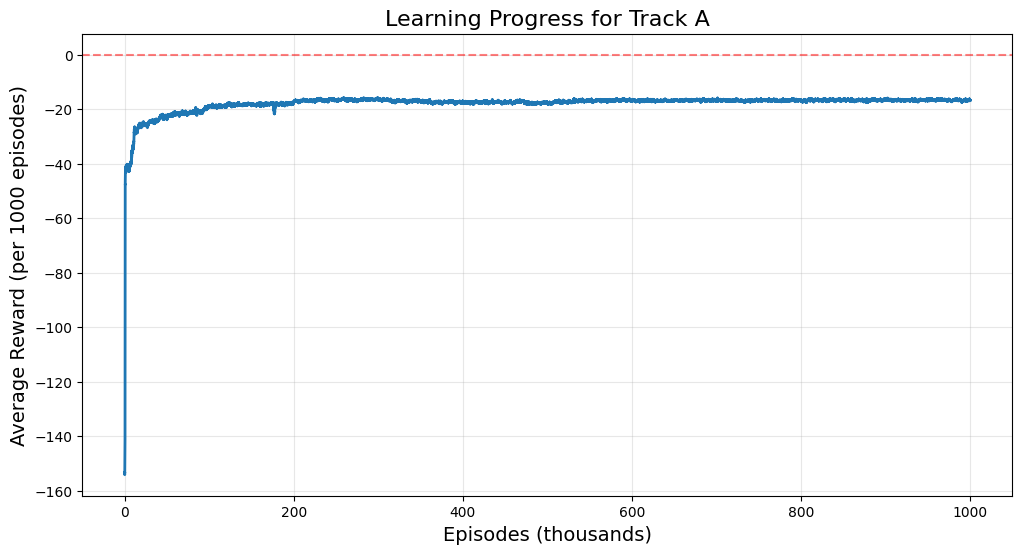

In [20]:
# Training and Performance Analysis for Off-Policy Monte Carlo Method

# Dictionaries to store training results
# Stores reward histories for different track configurations
reward_hist_dict = {}

# Stores learned Q-values for different track configurations
Q_dict = {}

# Generate a track identifier based on the selected track
track_name = f'Track {track_sel.capitalize()}'
key = track_name + ',' + 'Track map'

# Train the agent using the Off-Policy Monte Carlo Importance Sampling algorithm
reward_hist, Q = off_policy_monte_carlo(env, total_episodes, gamma, epsilon)

# Store the results in the respective dictionaries

# Store episode rewards
reward_hist_dict[key] = reward_hist

# Store Q-values representing the learned policy
Q_dict[key] = Q

# Save the trained Q-values to a pickle file for later use
with open(f'./history/track_{track_sel}.pkl', 'wb') as f:
    pickle.dump(Q_dict, f)

# Visualize learning progress
plt.figure(figsize=(12, 6))
plt.title(f'Learning Progress for {track_name}', fontsize=16)
plt.xlabel('Episodes (thousands)', fontsize=14)
plt.ylabel('Average Reward (per 1000 episodes)', fontsize=14)

# Apply moving average filter to smoothen the reward history for clearer visualization
window_size = 1000
smoothed_rewards = uniform_filter(reward_hist, size=window_size)

# Plot the smoothed rewards
x = np.arange(0, len(smoothed_rewards)) / 1000
plt.plot(x, smoothed_rewards, linewidth=2)
plt.grid(True, alpha=0.3)

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)

plt.savefig(f'./plots/track_{track_sel}_learning.png', bbox_inches='tight')
plt.show()

### **Plotting Results**  

To analyze the model's performance, we define a `plot_function` that visualizes the obtained results. This function helps us interpret **learning progress, convergence behavior, and policy effectiveness** by plotting key metrics such as **episode rewards, success rates, or policy updates**. By examining these plots, we can assess how the agent improves over time and compare different training conditions.

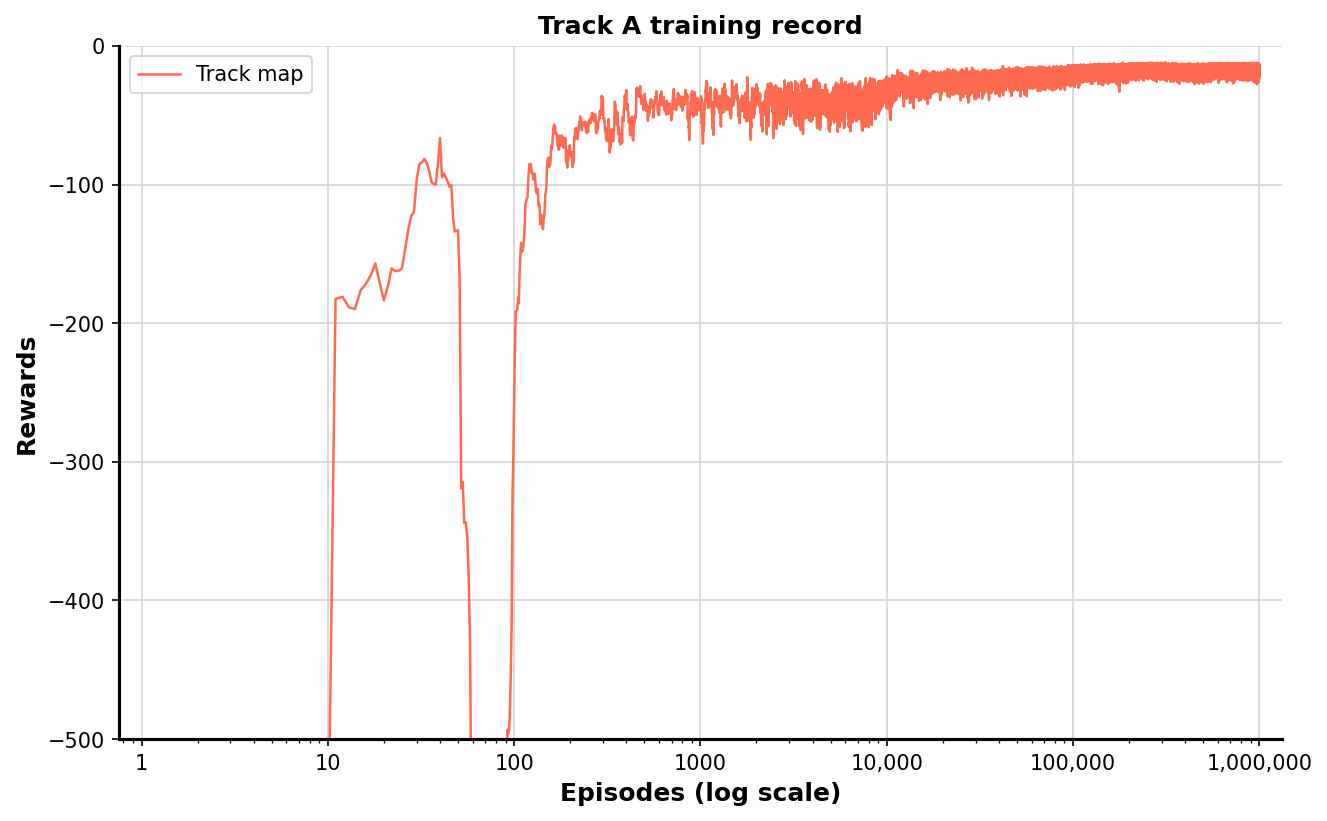

In [23]:
def plot_result(value_hist: dict, total_episodes) -> None:
    """
    Plot and save the training results in a nicely formatted graph.

    Parameters:
    - value_hist (dict): Dictionary containing the reward histories
    - total_episodes (int): Total number of training episodes
    """
    line_width = 1.2
    fontdict = {'fontsize': 12, 'fontweight': 'bold'}

    plt.figure(figsize=(10, 6), dpi=150)
    plt.ylim((-500.0, 0.0))
    plt.grid(c='lightgray')
    plt.margins(0.02)

    # Draw/remove axis lines
    for i, spine in enumerate(plt.gca().spines.values()):
        if i in [0, 2]:
            spine.set_linewidth(1.5)
            continue
        spine.set_visible(False)

    x = np.arange(total_episodes)
    plt.xscale('log')
    plt.xticks([1, 10, 100, 1000, 10_000, 100_000, 1_000_000],
               ['1', '10', '100', '1000', '10,000', '100,000', '1,000,000'])

    colors = ['tomato', 'cornflowerblue']
    for i, (key, value) in enumerate(value_hist.items()):
        title, label = key.split(',')
        plt.plot(x, uniform_filter(value, size=20),
                 linewidth=line_width,
                 label=label,
                 c=colors[i],
                 alpha=0.95)
    plt.title(title + ' training record', fontdict=fontdict)
    plt.xlabel('Episodes (log scale)', fontdict=fontdict)
    plt.ylabel('Rewards', fontdict=fontdict)
    plt.legend()
    plt.savefig(f'./plots/{"_".join(title.lower().split())}.png')
    plt.show()

# Plot the results
plot_result(reward_hist_dict, total_episodes)

# Save the Q-values to a pickle file
# Fixed typo: tr£ack_sel -> track_sel
with open(f'./history/track_{track_sel}.pkl', 'wb') as f:
    pickle.dump(Q_dict, f)

After completing the training phase, we can visualize the training history by calling the `plot_result` function as follows:

After training the two tracks a and b, we can observe that the policy **converges around the 10,000th episode** on both tracks.

### **Evaluating Q-Values and visualizing sample trajectories**

With the trained policies in place, we can now **test the agents** by allowing them to navigate the racetrack. To further assess the effectiveness of the learned policies, we evaluate the **Q-values** to ensure that the agent makes optimal decisions at each state. Additionally, we visualize **sample trajectories**, demonstrating how the agent navigates the track and verifying that it consistently follows an **efficient and stable path** toward the goal.

This implementation successfully **solves the racetrack challenge**, but there may still be areas for improvement.

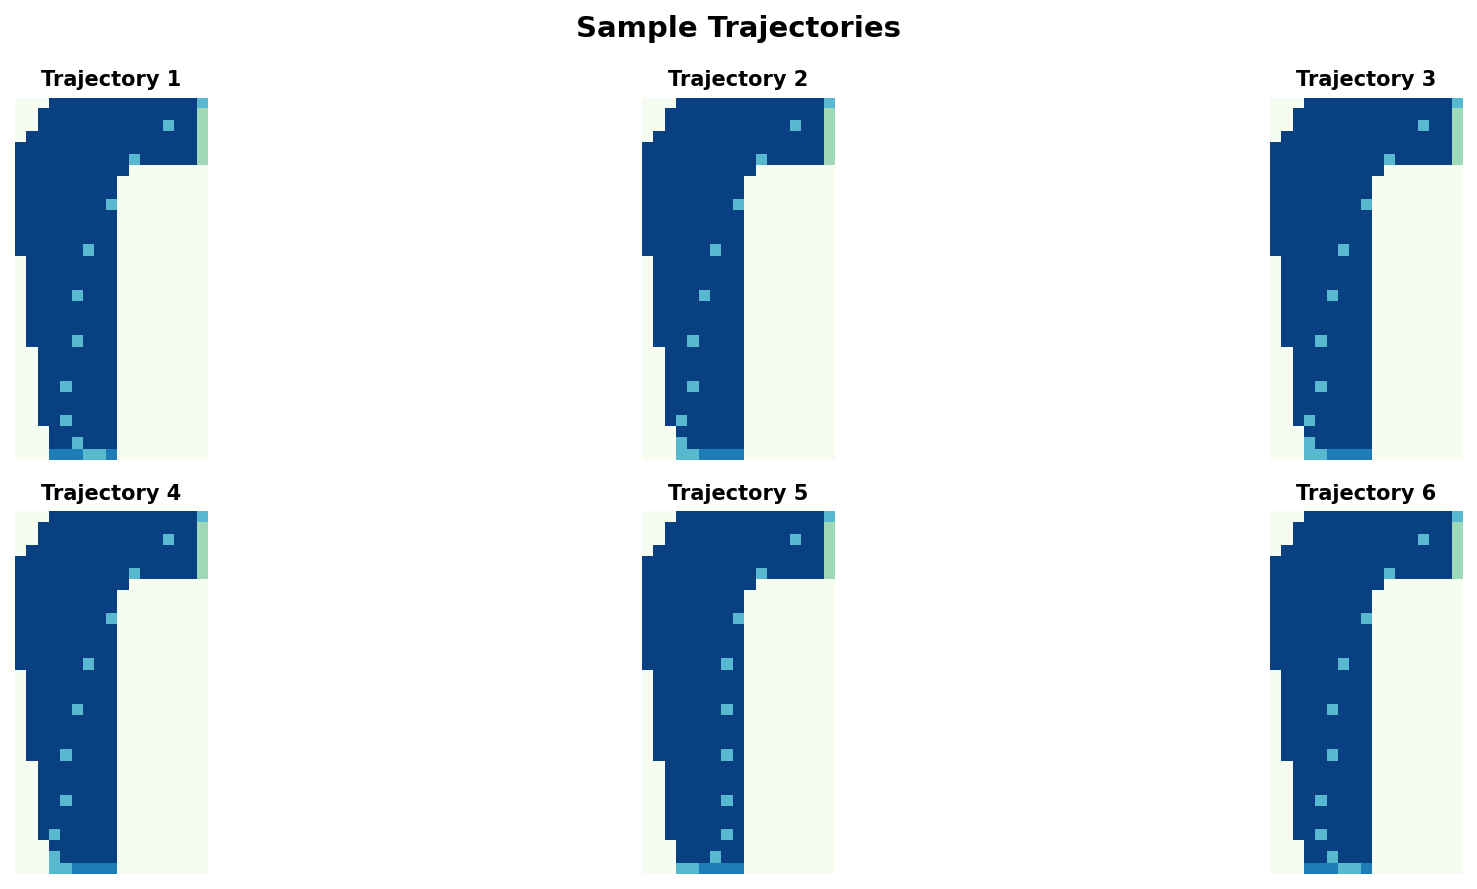


Demonstrating trained policy on Track A...
Demonstration completed!
Total steps: 12
Total reward: -12
Success: Yes


In [24]:
# Evaluating Q-Values and Visualizing Sample Paths in the Racetrack Environment

# Step 1: Set Up the Environment for Visualization

# Define the rendering mode (set to 'human' for visualization, None for faster processing)
render_mode = 'human'

# Select the racetrack configuration ('a' or 'b')
track_sel = 'a'

# Create the racetrack environment with the chosen track, rendering mode, and cell size
env = RaceTrack(track_sel, render_mode=render_mode, size=20)

# Step 2: Load the Pre-trained Q-Value Dictionary

# Load Q-values from a previously trained model stored in a pickle file
with open(f'./history/track_{track_sel}.pkl', 'rb') as f:
    Q_dict = pickle.load(f)

# Retrieve the first key in the dictionary (corresponding to the track)
key = list(Q_dict.keys())[0]
Q = Q_dict[key]

# Extract the learned policy using the greedy approach
policy = np.zeros(env.nS, dtype=int)
for state in np.ndindex(env.nS):
    policy[state] = np.argmax(Q[state])

# Step 3: Generate and Plot Sample Trajectories

# Create a figure for visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 6), dpi=150)
fig.suptitle('Sample Trajectories', fontsize=14, fontweight='bold')

# Generate and visualize 6 sample trajectories (for the 2x3 subplot grid)
for i, ax in enumerate(axes.flat):
    track_map = np.copy(env.track_map)  # Copy the track layout
    state, _ = env.reset()  # Reset environment to start position
    terminated = False  # Track if the episode ends
    truncated = False   # Track if episode is truncated
    max_steps = 500  # Prevent infinite loops
    step_count = 0

    while not (terminated or truncated) and step_count < max_steps:
        # Mark the agent's current position on the track
        track_map[state[0], state[1]] = 0.6

        # Select action based on the greedy policy
        action = policy[state]

        # Perform the action and observe the next state
        next_state, reward, terminated, truncated = env.step(action)

        # Break if the environment truncates the episode
        if truncated:
            break

        # Update the current state
        state = next_state

        # Increment step count
        step_count += 1

    # Plot the trajectory
    ax.imshow(track_map, cmap='GnBu', interpolation='nearest')
    ax.axis('off')
    ax.set_title(f'Trajectory {i+1}', fontsize=10, fontweight='bold')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(f'./plots/track_{track_sel}_paths.png', bbox_inches='tight')
plt.show()

# Step 4: Evaluate Policy Performance in Real-Time

# Reset environment for a final demonstration
env = RaceTrack(track_sel, render_mode='human', size=20)
state, _ = env.reset()
terminated = False
truncated = False
total_reward = 0
steps = 0

print(f"\nDemonstrating trained policy on {track_name}...")

# Run the policy until termination
while not (terminated or truncated) and steps < 1000:
    # Select the best action according to learned policy
    action = policy[state]

    # Take the action
    next_state, reward, terminated, truncated = env.step(action)

    # Update state and tracking variables
    state = next_state
    total_reward += reward
    steps += 1

    # Pause briefly to make visualization visible
    plt.pause(0.05)

print(f"Demonstration completed!")
print(f"Total steps: {steps}")
print(f"Total reward: {total_reward}")
print(f"Success: {'Yes' if terminated and not truncated else 'No'}")

<figure style="text-align: center;">
    <img src="./img/results.gif" alt="Agents driving on both tracks based on trained policies. Source." width="600"/>
    <figcaption>Agents driving on both tracks based on trained policies.</figcaption>
</figure>

## Conclusion
Congratulations on completing Assignment 5! This assignment provided hands-on experience with reinforcement learning, specifically in Off-policy Monte Carlo Control methods. The knowledge gained here will serve as a foundation for tackling more advanced RL challenges.